In [1]:
#pip install requests pymongo schedule tqdm psycopg2 pymongo psycopg2-binary


In [3]:
from datetime import datetime, timedelta
import pandas as pd
import requests
import pymongo
import schedule
import time
from tqdm import tqdm
from collections import OrderedDict


# Load stock tickers from a CSV file
data = pd.read_csv("/Users/yanghaoran/Desktop/5400 - MANAGING DATA/5400 Final Project/group/sp500_companies.csv")
tickers = data['Symbol'].unique()
ticker_list = tickers.tolist()

In [3]:
import sys
print(sys.executable)


/usr/local/bin/python3


In [4]:
# MongoDB setup
mongo_client = pymongo.MongoClient("mongodb://localhost:27017/")
mongo_db = mongo_client["5400Final"]  # Database name

In [5]:
#update 5 year data

In [5]:
from datetime import datetime, timedelta
import requests
from tqdm import tqdm
from collections import OrderedDict
import time
import schedule

# API details
url = "https://yfinance-stock-market-data.p.rapidapi.com/price-customdate"
headers = {
    "content-type": "application/x-www-form-urlencoded",
    "X-RapidAPI-Key": "adc30321e3msh9519a803e296a70p1150a2jsne7e28e57f358",
    "X-RapidAPI-Host": "yfinance-stock-market-data.p.rapidapi.com"
}

# Rate Limiting
request_count = 0
DAILY_LIMIT = 3000

def reset_request_count():
    global request_count
    request_count = 0

def update_daily():
    global request_count
    for ticker in tqdm(ticker_list, desc="Fetching data"):
        if request_count >= DAILY_LIMIT:
            print("Daily request limit reached. Waiting until reset...")
            break

        # MongoDB collection for this ticker
        mongo_collection = mongo_db[ticker]

        # Set the end date to today
        end_date = datetime.now()

        # Set start date 5 years ago
        start_date = end_date - timedelta(days=5*365)  # 5 years ago

        # Use a loop to cover the entire period in yearly increments if needed
        while start_date < end_date:
            current_end_date = min(start_date + timedelta(days=365), end_date)
            payload = {
                'symbol': ticker,
                'start': start_date.strftime("%Y-%m-%d"),
                'end': current_end_date.strftime("%Y-%m-%d")
            }

            response = requests.request("POST", url, data=payload, headers=headers)
            request_count += 1

            if response.status_code == 200:
                data = response.json().get('data')
                if data:
                    for day_data in data:
                        document = OrderedDict([
                            ("date", datetime.fromtimestamp(day_data['Date'] / 1000).strftime('%m-%d-%Y')),
                            ("date_utc", day_data['Date']),
                            ("open", day_data['Open']),
                            ("high", day_data['High']),
                            ("low", day_data['Low']),
                            ("close", day_data['Close']),
                            ("volume", day_data['Volume']),
                            ("adjclose", day_data['Adj Close'])
                        ])
                        mongo_collection.update_one(
                            {"date": document["date"]},
                            {"$set": document},
                            upsert=True
                        )
            else:
                print(f"Error retrieving data for {ticker}: {response.status_code}")

            # Move start date to just after current end date
            start_date = current_end_date + timedelta(days=1)
            time.sleep(0.2)  # Sleep to adhere to rate limits

# Schedule the request counter reset and daily updates
schedule.every().day.at("00:00").do(reset_request_count)
schedule.every().day.at("16:00").do(update_daily)

# Initial run and scheduler loop
update_daily()
# Uncomment these lines for a production run where the script needs to run continuously
# print("Scheduler started. Waiting to run at scheduled times...")
# while True:
#     schedule.run_pending()
#     time.sleep(60)  # Check every minute


Fetching data: 100%|██████████| 503/503 [43:12<00:00,  5.15s/it]


In [6]:
import psycopg2
import pymongo

In [7]:
# MongoDB setup
mongo_client = pymongo.MongoClient("mongodb://localhost:27017/")
mongo_db = mongo_client["5400Final"]  # Database name

In [8]:
# Create connection to PostgreSQL
pg_conn = psycopg2.connect(
    host="localhost",
    database="5400Final",
    user="postgres",
    password="123"
)

cur = pg_conn.cursor()

cur.execute("SELECT version();")

db_version = cur.fetchone()

print(f"Database version: {db_version[0]}")



Database version: PostgreSQL 16.1 (Debian 16.1-1.pgdg120+1) on aarch64-unknown-linux-gnu, compiled by gcc (Debian 12.2.0-14) 12.2.0, 64-bit


In [9]:
# Assuming mongo_db and pg_conn are already defined and connected to your MongoDB and PostgreSQL.

for ticker in ticker_list:
    pg_data = []  # Reset the pg_data for each ticker

    # Retrieve data from MongoDB collection
    mongo_collection = mongo_db[ticker]
    mongo_data = list(mongo_collection.find())

    # Transform data to the desired format
    for row in mongo_data[1:]:  # Assuming the first row is headers or irrelevant
        pg_row = {
            "date": row["date"],
            "open": row["open"],
            "high": row["high"],
            "low": row["low"],
            "close": row["close"],
            "volume": row["volume"],
            "adj_close": row.get("adjclose", row.get("adj_close"))  # Handle potential key variations
        }
        pg_data.append(pg_row)

    # Define table_name for PostgreSQL using the current ticker, and quote it if it's a reserved word
    table_name = ticker.upper().replace("-", "_")
    # Check for reserved SQL keywords 'ALL' and 'ON'
    if table_name in ['ALL', 'ON']:
        quoted_table_name = f'"{table_name.lower()}"'
    else:
        quoted_table_name = table_name

    with pg_conn.cursor() as pg_cur:
        # Create the table if it doesn't exist
        pg_cur.execute(f"""
            CREATE TABLE IF NOT EXISTS {quoted_table_name} (
                date DATE PRIMARY KEY,
                open FLOAT,
                high FLOAT,
                low FLOAT,
                close FLOAT,
                volume BIGINT,
                adj_close FLOAT
            )
        """)

        # Prepare the INSERT INTO statement with placeholders for the actual values
        insert_statement = f"""
            INSERT INTO {quoted_table_name} (
                date, open, high, low, close, volume, adj_close
            ) VALUES (
                %s, %s, %s, %s, %s, %s, %s
            ) ON CONFLICT (date) DO UPDATE SET
                open = EXCLUDED.open,
                high = EXCLUDED.high,
                low = EXCLUDED.low,
                close = EXCLUDED.close,
                volume = EXCLUDED.volume,
                adj_close = EXCLUDED.adj_close
        """

        # Execute the insert statement for each row in pg_data
        for row in pg_data:
            pg_cur.execute(insert_statement, (
                row['date'],
                row['open'],
                row['high'],
                row['low'],
                row['close'],
                row['volume'],
                row['adj_close']
            ))

        # Commit the transaction to make sure changes are saved
        pg_conn.commit()


KeyboardInterrupt: 

In [10]:
#!pip install pandas numpy matplotlib seaborn psycopg2

In [11]:
#!pip install matplotlib


In [12]:
#!pip install seaborn

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import psycopg2

In [11]:
# Connect to PostgreSQL database
pg_conn = psycopg2.connect(
    host="localhost",
    database="5400Final",
    user="postgres",
    password="123"
)

In [12]:
pip install plotly



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


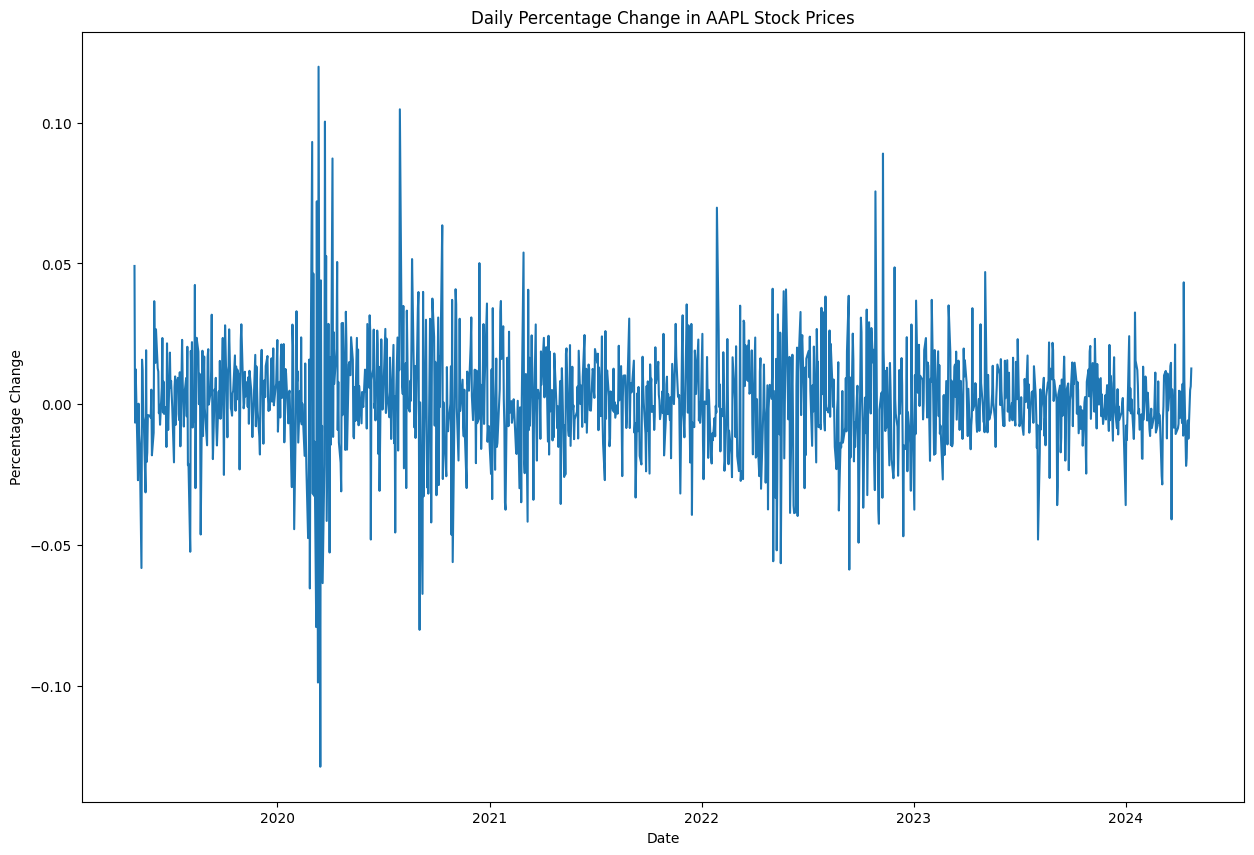

In [13]:

# Define function to retrieve data for a given ticker
def get_data(ticker):
    with pg_conn.cursor() as pg_cur:
        pg_cur.execute("SELECT * FROM {table_name} ORDER BY date ASC".format(table_name=ticker))
        rows = pg_cur.fetchall()
    return pd.DataFrame(rows, columns=['date', 'open', 'high', 'low', 'close', 'volume', 'adj_close'])


# Define function to calculate daily percentage change in stock prices
def daily_pct_change(df):
    return df['adj_close'].pct_change()

# Define function to plot the daily percentage change in stock prices
def plot_pct_change(df, ticker):
    plt.figure(figsize=(15,10))
    sns.lineplot(x='date', y='pct_change', data=df)
    plt.title("Daily Percentage Change in {} Stock Prices".format(ticker))
    plt.xlabel("Date")
    plt.ylabel("Percentage Change")
    plt.show()

# Example usage
df = get_data('AAPL') 
df['pct_change'] = daily_pct_change(df)
plot_pct_change(df, 'AAPL')

In [17]:
pip install --upgrade nbformat

Note: you may need to restart the kernel to use updated packages.


In [18]:
import plotly.express as px

# Define function to plot the daily percentage change in stock prices using Plotly for interactivity
def plot_pct_change_plotly(df, ticker):
    fig = px.line(df, x='date', y='pct_change', title=f"Daily Percentage Change in {ticker} Stock Prices")
    fig.update_layout(xaxis_title='Date', yaxis_title='Percentage Change', title_x=0.5)
    fig.show()

# Assuming get_data and daily_pct_change functions are defined as above

# Example usage with Plotly
df = get_data('AAPL') 
df['pct_change'] = daily_pct_change(df)
plot_pct_change_plotly(df, 'AAPL')


In [19]:
pip install sklearn

  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  Preparing metadata (setup.py) ... error
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [15 lines of output]
      The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
      rather than 'sklearn' for pip commands.
      
      Here is how to fix this error in the main use cases:
      - use 'pip install scikit-learn' rather than 'pip install sklearn'
      - replace 'sklearn' by 'scikit-learn' in your pip requirements files
        (requirements.txt, setup.py, setup.cfg, Pipfile, etc ...)
      - if the 'sklearn' package is used by one of your dependencies,
        it would be great if you take some time to track which package uses
        'sklearn' instead of 'scikit-learn' and report it to their issue tracker
      - as a last resort, set the environment variable
        SKLEARN_ALLOW_DEPRECATED_SKLEARN_PACKAGE_INSTALL=True to avoid this error
      
    

In [20]:
pip install -U scikit-learn


Note: you may need to restart the kernel to use updated packages.


In [21]:


import pandas as pd
import numpy as np


from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Define function to prepare data for classification model
def prepare_data(df):
    X = df[['open', 'high', 'low', 'close', 'volume', 'adj_close']].values[:-1]
    y = np.where(df['adj_close'].shift(-1) > df['adj_close'], 1, 0)[:-1]
    return X, y

# Define function to train and test a decision tree classification model
def train_test_model(df):
    X, y = prepare_data(df)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    clf = DecisionTreeClassifier(max_depth=3, random_state=42)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return accuracy_score(y_test, y_pred)

# Example usage
df = get_data('AAPL')
accuracy = train_test_model(df)
print("Accuracy of decision tree model for AAPL: {:.2f}%".format(accuracy * 100))

Accuracy of decision tree model for AAPL: 50.40%


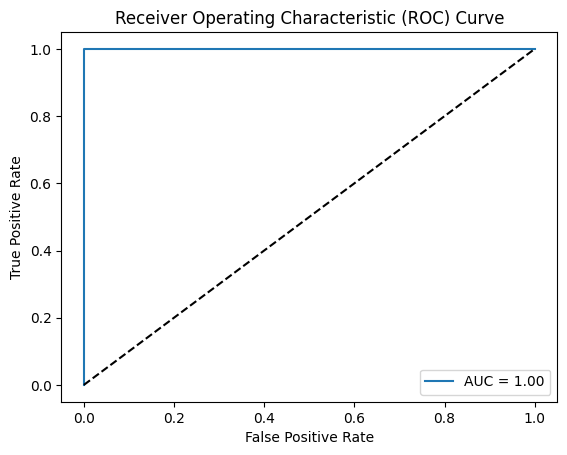

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Assuming you have true labels and predicted probabilities
true_labels = np.array([0, 0, 1, 1, 0, 1])
predicted_probs = np.array([0.2, 0.3, 0.6, 0.8, 0.4, 0.7])

# Compute the false positive rate (FPR), true positive rate (TPR), and thresholds
fpr, tpr, thresholds = roc_curve(true_labels, predicted_probs)

# Compute the AUC (Area Under the Curve)
auc_score = auc(fpr, tpr)

# Plot the AOC curve
plt.plot(fpr, tpr, label='AUC = {:.2f}'.format(auc_score))
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line representing random guessing
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


In [23]:
############################################################################################################
##################################   Flask   #############################################################

In [24]:
pip install Flask

Note: you may need to restart the kernel to use updated packages.


In [14]:
from flask import Flask, render_template, request, redirect, url_for
import psycopg2
from datetime import datetime, timedelta
import base64
import io
from matplotlib import pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
import numpy as np

app = Flask(__name__)

# Set up PostgreSQL connection
pg_conn = psycopg2.connect(
    host="localhost",
    port=5432,
    database="5400Final",
    user="postgres",
    password="123"
)

@app.route("/", methods=['GET', 'POST'])
def home():
    if request.method == 'POST':
        ticker = request.form['ticker']
        return redirect(url_for('results', ticker=ticker))
    return render_template("home.html")

@app.route("/results/<ticker>")
def results(ticker):
    date_30_days_ago = datetime.now() - timedelta(days=120)
    with pg_conn.cursor() as pg_cur:
        query = """
            SELECT date, open, high, low, close, volume, adj_close
            FROM {table_name}
            WHERE date >= %s
        """.format(table_name=ticker.upper())
        pg_cur.execute(query, [date_30_days_ago])
        pg_data = pg_cur.fetchall()

    if not pg_data:
        return "No data available for this ticker in the last 30 days."
    
    # Perform analysis, round to 3 decimal places
    max_price_data = max(pg_data, key=lambda x: x[2])
    min_price_data = min(pg_data, key=lambda x: x[3])
    max_price = (max_price_data[0], round(max_price_data[2], 3))
    min_price = (min_price_data[0], round(min_price_data[3], 3))
    avg_price = round(sum([row[4] for row in pg_data]) / len(pg_data), 3)

    # Decision Tree Graph
    image_base64_rf = generate_decision_tree_graph(pg_data, ticker)

    # Linear Regression Graph
    image_base64_lr = generate_linear_regression_graph(pg_data, ticker)
    
    #Past 5 year Data
    image_base64_5y = fetch_and_plot_five_year_data(ticker)

    return render_template("results.html", ticker=ticker.upper(),max_price=max_price, min_price=min_price,
                        avg_price=avg_price, image_base64_5y=image_base64_5y,
                           image_base64_rf=image_base64_rf,
                           image_base64_lr=image_base64_lr)

def generate_decision_tree_graph(data, ticker):
    x = [i for i in range(len(data))]
    y = [row[4] for row in data]
    model = DecisionTreeRegressor()
    model.fit(np.array(x).reshape(-1, 1), y)
    future_x = [len(data) + i for i in range(5)]
    future_y = model.predict(np.array(future_x).reshape(-1, 1))
    fig, ax = plt.subplots()
    ax.plot(x, y, label="Historical Data")
    ax.plot(future_x, future_y, linestyle='--', label="Predicted Data")
    ax.set(xlabel="Time (days)", ylabel="Closing Price ($)", title="Decision Tree Predicted Trend for " + ticker)
    ax.legend()
    return fig_to_base64(fig)

def generate_linear_regression_graph(data, ticker):
    x = [i for i in range(len(data))]
    y = [row[4] for row in data]
    model = LinearRegression()
    model.fit(np.array(x).reshape(-1, 1), y)
    future_x = [len(data) + i for i in range(5)]
    future_y = model.predict(np.array(future_x).reshape(-1, 1))
    fig, ax = plt.subplots()
    ax.plot(x, y, label="Historical Data")
    ax.plot(future_x, future_y, linestyle='--', label="Predicted Data")
    ax.set(xlabel="Time (days)", ylabel="Closing Price ($)", title="Linear Regression Predicted Trend for " + ticker)
    ax.legend()
    return fig_to_base64(fig)

def fetch_and_plot_five_year_data(ticker):
    # Calculate the date 5 years ago from today
    date_5_years_ago = datetime.now() - timedelta(days=5 * 365)

    # Fetch data for the past 5 years
    with pg_conn.cursor() as pg_cur:
        query = """
            SELECT date, close
            FROM {table_name}
            WHERE date >= %s
            ORDER BY date
        """.format(table_name=ticker.upper())
        pg_cur.execute(query, [date_5_years_ago])
        historical_data = pg_cur.fetchall()

    if not historical_data:
        return None

    # Prepare data for plotting
    dates = [row[0] for row in historical_data]
    prices = [row[1] for row in historical_data]

    # Create plot
    fig, ax = plt.subplots()
    ax.plot(dates, prices, label='Closing Prices Over 5 Years')
    ax.set(xlabel='Date', ylabel='Closing Price ($)', title=f'5 Year Closing Price Trend for {ticker.upper()}')
    ax.legend()

    return fig_to_base64(fig)


def fig_to_base64(fig):
    buf = io.BytesIO()
    fig.savefig(buf, format='png')
    plt.close(fig)
    buf.seek(0)
    return base64.b64encode(buf.getvalue()).decode()

if __name__ == "__main__":
    app.run(debug=True, use_reloader=False, port=5004)


 * Serving Flask app '__main__'
 * Debug mode: on


 * Running on http://127.0.0.1:5004
Press CTRL+C to quit
127.0.0.1 - - [25/Apr/2024 09:54:21] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [25/Apr/2024 09:54:22] "GET /favicon.ico HTTP/1.1" 404 -
127.0.0.1 - - [25/Apr/2024 09:54:25] "POST / HTTP/1.1" 302 -
127.0.0.1 - - [25/Apr/2024 09:54:25] "GET /results/AAPL HTTP/1.1" 200 -
127.0.0.1 - - [25/Apr/2024 09:57:40] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [25/Apr/2024 10:26:55] "GET / HTTP/1.1" 200 -
